<a href="https://colab.research.google.com/github/devanshjoshi104/Andrej-YT-Lecture/blob/main/Lecture6_makemore_wavenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import random

In [2]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2024-12-30 16:31:57--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.02s   

2024-12-30 16:31:57 (9.60 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [109]:
# params
sample_data_size = len(words)
# sample_data_size = 5
embedding_dim_size = 10
block_size = 8
neural_net_nodes = 68
g = torch.Generator().manual_seed(2147483647)
vocab_size = len(itos)

In [63]:
def build_dataset(words):
  X, Y = [], []
  for w in words[:sample_data_size]:
      context = [0] * block_size
      for ch in w + '.':
          ix = stoi[ch]
          X.append(context)
          Y.append(ix)
          # print(''.join(itos[i] for i in context), '--->', itos[ix])
          context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y


In [64]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X,Y = build_dataset(words[:n1])
Xval,Yval = build_dataset(words[n1:n2])
Xtest,Ytest = build_dataset(words[n2:])


In [116]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# ----------------------------------------------------------------------------------------------------

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if x.ndim == 2:
      dim = 0
    elif x.ndim == 3:
      dim = (0,1)
    if self.training:
      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

  # ----------------------------------------------------------------------------------------------------

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
 # ----------------------------------------------------------------------------------------------------

class Embedding:
  def __init__(self, num_embeddings, embedding_dim_size):
    self.weight = torch.randn((num_embeddings, embedding_dim_size))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

  # ----------------------------------------------------------------------------------------------------
class Flatten:
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

    # ----------------------------------------------------------------------------------------------------
class FlattenConsecutive:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T // self.n , self.n * C)

    if x.shape[1] == 1:
      x = x.squeeze(1)

    self.out = x
    return self.out

  def parameters(self):
    return []

  # ----------------------------------------------------------------------------------------------------

class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
        x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

  def requires_params_grad(self):
    for p in self.parameters():
      p.requires_grad = True

  def reset_params_grad(self):
    for p in self.parameters():
      p.grad = None

  def update_layers_weight(self):
    with torch.no_grad():
      self.layers[-1].weight*=0.1

      for layer in self.layers:
        if isinstance(layer, Linear):
          layer.weight *= 5/3

  def enable_training_mode(self):
    for layer in self.layers:
      layer.training = False

  # for debug purposes
  def print_layers_shape(self):
    for layer in self.layers:
      # print(layer.__class__.__name__)
      print(layer.__class__.__name__, ':', layer.out.shape)


In [14]:
torch.manual_seed(42)

In [117]:
consecutive_concat_size = 2
model = Sequential([
          Embedding(vocab_size, embedding_dim_size),

          FlattenConsecutive(consecutive_concat_size),
          Linear(embedding_dim_size * consecutive_concat_size, neural_net_nodes, bias=False),
          BatchNorm1d(neural_net_nodes),
          Tanh(),

          FlattenConsecutive(consecutive_concat_size),
          Linear(neural_net_nodes * consecutive_concat_size, neural_net_nodes, bias=False),
          BatchNorm1d(neural_net_nodes),
          Tanh(),

          FlattenConsecutive(consecutive_concat_size),
          Linear(neural_net_nodes * consecutive_concat_size, neural_net_nodes, bias=False),
          BatchNorm1d(neural_net_nodes),
          Tanh(),

          Linear(neural_net_nodes, vocab_size) ])

model.update_layers_weight()

print(sum(p.nelement() for p in model.parameters()))
model.requires_params_grad()


22397


In [108]:

model.print_layers_shape()

Embedding : torch.Size([4, 8, 10])
FlattenConsecutive : torch.Size([4, 4, 20])
Linear : torch.Size([4, 4, 200])
BatchNorm1d : torch.Size([4, 4, 200])
Tanh : torch.Size([4, 4, 200])
FlattenConsecutive : torch.Size([4, 2, 400])
Linear : torch.Size([4, 2, 200])
BatchNorm1d : torch.Size([4, 2, 200])
Tanh : torch.Size([4, 2, 200])
FlattenConsecutive : torch.Size([4, 400])
Linear : torch.Size([4, 200])
BatchNorm1d : torch.Size([4, 200])
Tanh : torch.Size([4, 200])
Linear : torch.Size([4, 27])


In [118]:
max_items = 2_00_000
batch_size = 32
lossi = []

for i in range(max_items):
  # batches
  ix = torch.randint(0, X.shape[0], (batch_size,))
  Xb, Yb = X[ix], Y[ix]

  # forward pass
  x = model(Xb)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  model.reset_params_grad()
  loss.backward()

  # update
  lr = 0.1 if i < 1_20_000 else 0.01
  for p in model.parameters():
    p.data+= - lr * p.grad

  lossi.append(loss.log10().item())
  if i % 10000 == 0:
    print(f'{i:7d}/{max_items:7d}: {loss.item():.4f}')

      0/ 200000: 3.2961
  10000/ 200000: 2.4718
  20000/ 200000: 2.2032
  30000/ 200000: 2.1848
  40000/ 200000: 1.8253
  50000/ 200000: 2.1608
  60000/ 200000: 2.3442
  70000/ 200000: 1.9743
  80000/ 200000: 1.7541
  90000/ 200000: 1.8047
 100000/ 200000: 1.7431
 110000/ 200000: 1.9105
 120000/ 200000: 1.3675
 130000/ 200000: 2.1674
 140000/ 200000: 2.3086
 150000/ 200000: 1.9972
 160000/ 200000: 2.1714
 170000/ 200000: 1.9780
 180000/ 200000: 1.9125
 190000/ 200000: 2.0506


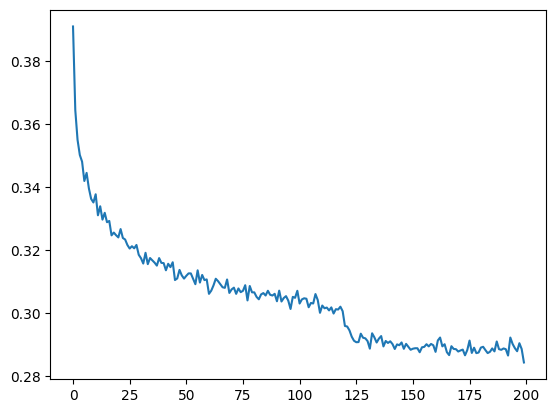

In [119]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))


In [120]:
model.enable_training_mode()
with torch.no_grad():
  def print_loss(type):
    x,y = {'train' : (X, Y),
           'val' : (Xval, Yval),
           'test': (Xtest, Ytest)} [type]

    # forward pass
    x = model(x)

    loss = F.cross_entropy(x, y)
    print(type, loss.item())
    return loss


In [121]:
print_loss('train')
print_loss('val')

train 1.9264129400253296
val 2.0252203941345215


tensor(2.0252, grad_fn=<NllLossBackward0>)

torch.Size([100, 23, 4, 5, 200])